In [1]:
import torch
import os
import torch.nn.init as init
from torchvision import datasets, transforms
from torch import optim, nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import logging
import math

In [2]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = './combined_out'

In [3]:
train_settings = {
    "Baseline_0": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": None, "factor": 1},
    "Baseline_1": {"epochs": 4, "lr": 0.001, "l2": 1e-4, "loss_type": None, "factor": 1},
    "Baseline_2": {"epochs": 4, "lr": 0.0001, "l2": 1e-4, "loss_type": None, "factor": 1},

    "combined_0": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [10, [0, 2., 4., 6., 8.]]},
    "combined_1": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [20, [0, 2., 4., 6., 8.]]},
    "combined_2": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [40, [0, 2., 4., 6., 8.]]},
    "combined_3": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                         "factor":  [10, [0, 1., 2., 3., 4.]]},
    "combined_4": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [20, [0, 1., 2., 3., 4.]]},
    "combined_5": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [40, [0, 1., 2., 3., 4.]]},
    "combined_6": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                         "factor":  [10, [0, 1.5, 3., 6., 12]]},
    "combined_7": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [20, [0, 1.5, 3., 6., 12]]},
    "combined_8": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [40, [0, 1.5, 3., 6., 12]]},
    "combined_9": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2, 3.5, 6., 8]]},
    "combined_10": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2, 3.5, 6., 12]]},
    "combined_11": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [[15, 20, 15, 15, 10], [0, 2, 3.5, 6., 12]]},
    "combined_12": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution_v2", "follow_leader"], 
                                                          "factor": [1, [0, 2, 3.5, 6., 12]]},
    "combined_13": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader_v2"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2, 1.75, 2., 3]]},
    "combined_14": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader_v3"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2, 1.75, 2., 3]]},
    "combined_15": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader_v3"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2., 2., 2., 1.]]},
    "combined_16": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader_v3"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2., 2., 2., 2.]]},
    "combined_17": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader_v3"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2., 2., 2., 3.]]},
    "combined_18": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader_v3"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2., 2., 2., 4.]]},
    "combined_19": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader_v4"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2., 2., 2., 2.]]},
}


## Dataloader

In [4]:
tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

In [5]:
def task_dataloader(task_num):
    task_dir = {0: [0, 1], 1: [2, 3], 2: [4, 5], 3: [6, 7], 4:[8, 9]}

    train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=tf)

    indices = [i for i, (_, label) in enumerate(train_dataset) if label in task_dir[task_num]]
    dataset = Subset(train_dataset, indices)
    task_train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    indices = [i for i, (_, label) in enumerate(test_dataset) if label in task_dir[task_num]]
    dataset = Subset(test_dataset, indices)
    task_test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return task_train_loader, task_test_loader

def load_all_data():
    train_dataset = datasets.MNIST(root='./data', train=True, transform=tf, download=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, test_loader

In [6]:
def adjust_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.75 * param_group['lr']

In [7]:
class MLP_Enhance(nn.Module):
    def __init__(self, out_dim=10, in_channel=1, img_sz=28, hidden_dim=400):
        super(MLP_Enhance, self).__init__()
        self.in_dim = in_channel*img_sz*img_sz
        self.linear = nn.Sequential(
            nn.Linear(self.in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )
        self.last = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax(dim=1)
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.linear:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                init.constant_(layer.bias, 0)
        last_linear = self.last[0]
        init.xavier_normal_(last_linear.weight)
        init.constant_(last_linear.bias, 0)


    def features(self, x):
        x = self.linear(x.view(-1,self.in_dim))
        return x

    def logits(self, x):
        x = self.last(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x

In [8]:
train_loader, test_loader = load_all_data()
task_dataloaders = {}
for task in range(0, 5):
    train_dl, test_ld = task_dataloader(task)
    task_dataloaders[task] = (train_dl, test_ld)

In [9]:
def cal_acc(model, dataloader, device):
    model.eval()
    correct, total = 0., 0.
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [10]:
def plot_acc_history(all_accuracies):
    plt.figure(figsize=(18, 12))

    for i, task_accuracies in enumerate(all_accuracies):
        plt.subplot(2, 3, i+1)
        for task, accs in task_accuracies.items():
            plt.plot(accs,'-', label=f'Task {task}')
        plt.title(f'Accuracy per Mini-Batch for Task {i}')
        plt.xlabel('Mini-Batch Number')
        plt.ylabel('Accuracy (%)')
        plt.ylim(-5, 105)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_task_acc_history(all_accuracies, save_name, epochs):
    for task in [0, 1, 2, 3, 4]:
        if (task == 0):
            task_history = []
        else:
            task_history =  [0] * (epochs * 10 * task)
        for i, task_accuracies in enumerate (all_accuracies):
            if (i >= task):
                task_history.extend(task_accuracies[task])
                    
        plt.plot(task_history, '-', label=f'Task {task}')

    plt.xlabel('Mini-Batch Number')
    plt.ylabel('Accuracy (%)')
    plt.ylim(-5, 105)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_name) 
    plt.show()

# Train

In [11]:
def train(model, task_num, criterion, prev_model, epoches = 4, lr = 0.001, l2 = None, loss_type = None, factor = 1):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    if l2 is None:
        optimizer_F = torch.optim.Adam(follower.parameters(), lr)
    else:
        optimizer_F = torch.optim.Adam(follower.parameters(), lr, weight_decay = l2)
        
    train_loader = task_dataloaders[task_num][0]

    task_accuracies = {task: [] for task in range(task_num + 1)}


    if (isinstance(factor[0], int) or isinstance(factor[0], float) ):
        distribution_factor = factor[0]
    else:
        distribution_factor = factor[0][task_num]
    
    if (isinstance(factor[1], int) or isinstance(factor[1], float) ):
        follow_leader_factor = factor[1]
    else:
        follow_leader_factor = factor[1][task_num]
    
    valid_out_dim = task_num * 2 + 2
    logging.info(f"##########Task {task_num}##########")
    for e in range(epoches):
        logging.info(f"Epoch {e}")
        batch_num = 0
        for images, labels in train_loader:
            follower.train()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)

            reg_loss = 0
            
            if ("follow_leader" in loss_type):
                with torch.no_grad():
                    leader_output = model(images)
                
                if (task_num != 0):
                    reg_loss += follow_leader_factor * torch.mean(torch.abs(leader_output[:,:valid_out_dim - 2] - outputs[:,:valid_out_dim - 2]))
            if ("follow_leader_v2" in loss_type):
                for k, mod in enumerate(prev_model):
                    with torch.no_grad():
                        leader_output = mod(images)
                    reg_loss += follow_leader_factor * torch.mean(torch.abs(leader_output[:,:valid_out_dim - 2] - outputs[:,:valid_out_dim - 2]))
            if ("follow_leader_v3" in loss_type):
                for k, mod in enumerate(prev_model):
                    with torch.no_grad():
                        leader_output = mod(images)
                    reg_loss += follow_leader_factor * torch.mean(torch.abs(leader_output[:,k*2:k * 2 + 2] - outputs[:,k*2:k * 2 + 2]))
            if ("follow_leader_v4" in loss_type):
                for k, mod in enumerate(prev_model):
                    with torch.no_grad():
                        leader_output = mod(images)
                    reg_loss += follow_leader_factor / task_num * torch.mean(torch.abs(leader_output[:,k*2:k * 2 + 2] - outputs[:,k*2:k * 2 + 2]))
            if ("distribution" in loss_type):
                random_data = torch.rand(batch_size, 1, 28, 28).to(device)
                random_data = (random_data - 0.5) / 0.5
                random_target = torch.randint(0, 10, (batch_size,), dtype=torch.int64).to(device)
                fake_output = follower(random_data)
                reg_loss += distribution_factor * criterion(fake_output, random_target)
            if ("distribution_v2" in loss_type):
                except_mean = 0.1
                for task in range (10):
                    task_start = task
                    task_end = (task + 1)

                    fake_image = torch.randn(batch_size, 1, 28, 28).to(device)
                    fake_image = (fake_image - 0.5) / 0.5
                    fake_output = follower(fake_image)

                    real_mean = torch.mean(torch.abs(fake_output[:,task_start:task_end]))
                    reg_loss += distribution_factor * torch.abs(except_mean - real_mean)

            loss = criterion(outputs[:,:valid_out_dim], labels) + reg_loss
            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

            if(batch_num % 10 == 0):
                avg_acc = 0
                log_message = []
                for task in range(task_num + 1):
                    acc = cal_acc(follower, task_dataloaders[task][0], device)
                    avg_acc += acc
                    task_accuracies[task].append(acc * 100)
                    log_message.append(f"Batch num: {batch_num}, Task {task} acc: {acc * 100:.4f}")

                logging.info(', '.join(log_message) + f", Task avg acc:{avg_acc*100/(task_num + 1):.4f}")

            batch_num += 1

        adjust_learning_rate(optimizer_F)
    
    return follower, task_accuracies

In [12]:
def setup_logging(task_name, epochs, lr, factor, l2):
    log_filename = f"{output_dir}/{task_name}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.log"
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s',
                        handlers=[
                            logging.FileHandler(log_filename),
                            logging.StreamHandler()
                        ],
                        force=True)
    
def train_split_task(task_name):
    print(f"Training on {task_name}")
    prev_model = []
    model = MLP_Enhance()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    settings = train_settings[task_name]
    epochs, lr, l2, loss_type, factor = settings['epochs'], settings['lr'], settings['l2'], settings['loss_type'], settings['factor']


    if os.path.exists(f"{output_dir}/{task_name}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.log") == False:
        setup_logging(task_name, epochs, lr, factor, l2)
        all_accuracies = []
        for task in [0, 1, 2, 3, 4]:
            model, task_accuracies = train(model, task, criterion, prev_model, epoches = epochs, lr = lr, l2 = l2, loss_type = loss_type, factor = factor)
            all_accuracies.append(task_accuracies)
            prev_model.append(model)

        plot_task_acc_history(all_accuracies, f"{output_dir}/{task_name}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.png", epochs)

Training on Baseline_0
Training on Baseline_1
Training on Baseline_2
Training on combined_0
Training on combined_1
Training on combined_2
Training on combined_3
Training on combined_4
Training on combined_5
Training on combined_6
Training on combined_7
Training on combined_8
Training on combined_9
Training on combined_10
Training on combined_11
Training on combined_12
Training on combined_13
Training on combined_14
Training on combined_15
Training on combined_16
Training on combined_17
Training on combined_18
Training on combined_19


2024-05-29 20:43:12,365 - INFO - ##########Task 0##########
2024-05-29 20:43:12,366 - INFO - Epoch 0
2024-05-29 20:43:15,026 - INFO - Batch num: 0, Task 0 acc: 32.6291, Task avg acc:32.6291
2024-05-29 20:43:17,430 - INFO - Batch num: 10, Task 0 acc: 53.5475, Task avg acc:53.5475
2024-05-29 20:43:19,806 - INFO - Batch num: 20, Task 0 acc: 55.9232, Task avg acc:55.9232
2024-05-29 20:43:22,363 - INFO - Batch num: 30, Task 0 acc: 73.9716, Task avg acc:73.9716
2024-05-29 20:43:24,889 - INFO - Batch num: 40, Task 0 acc: 90.7685, Task avg acc:90.7685
2024-05-29 20:43:27,447 - INFO - Batch num: 50, Task 0 acc: 97.5128, Task avg acc:97.5128
2024-05-29 20:43:29,947 - INFO - Batch num: 60, Task 0 acc: 98.0389, Task avg acc:98.0389
2024-05-29 20:43:32,469 - INFO - Batch num: 70, Task 0 acc: 97.7519, Task avg acc:97.7519
2024-05-29 20:43:35,063 - INFO - Batch num: 80, Task 0 acc: 97.4729, Task avg acc:97.4729
2024-05-29 20:43:37,577 - INFO - Batch num: 90, Task 0 acc: 98.1425, Task avg acc:98.1425


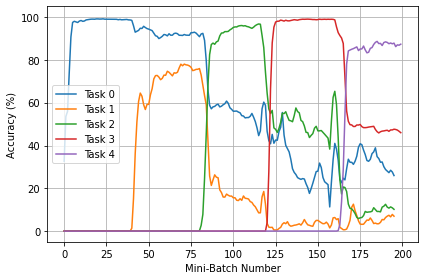

In [13]:
for key in train_settings.keys():
    train_split_task(key)

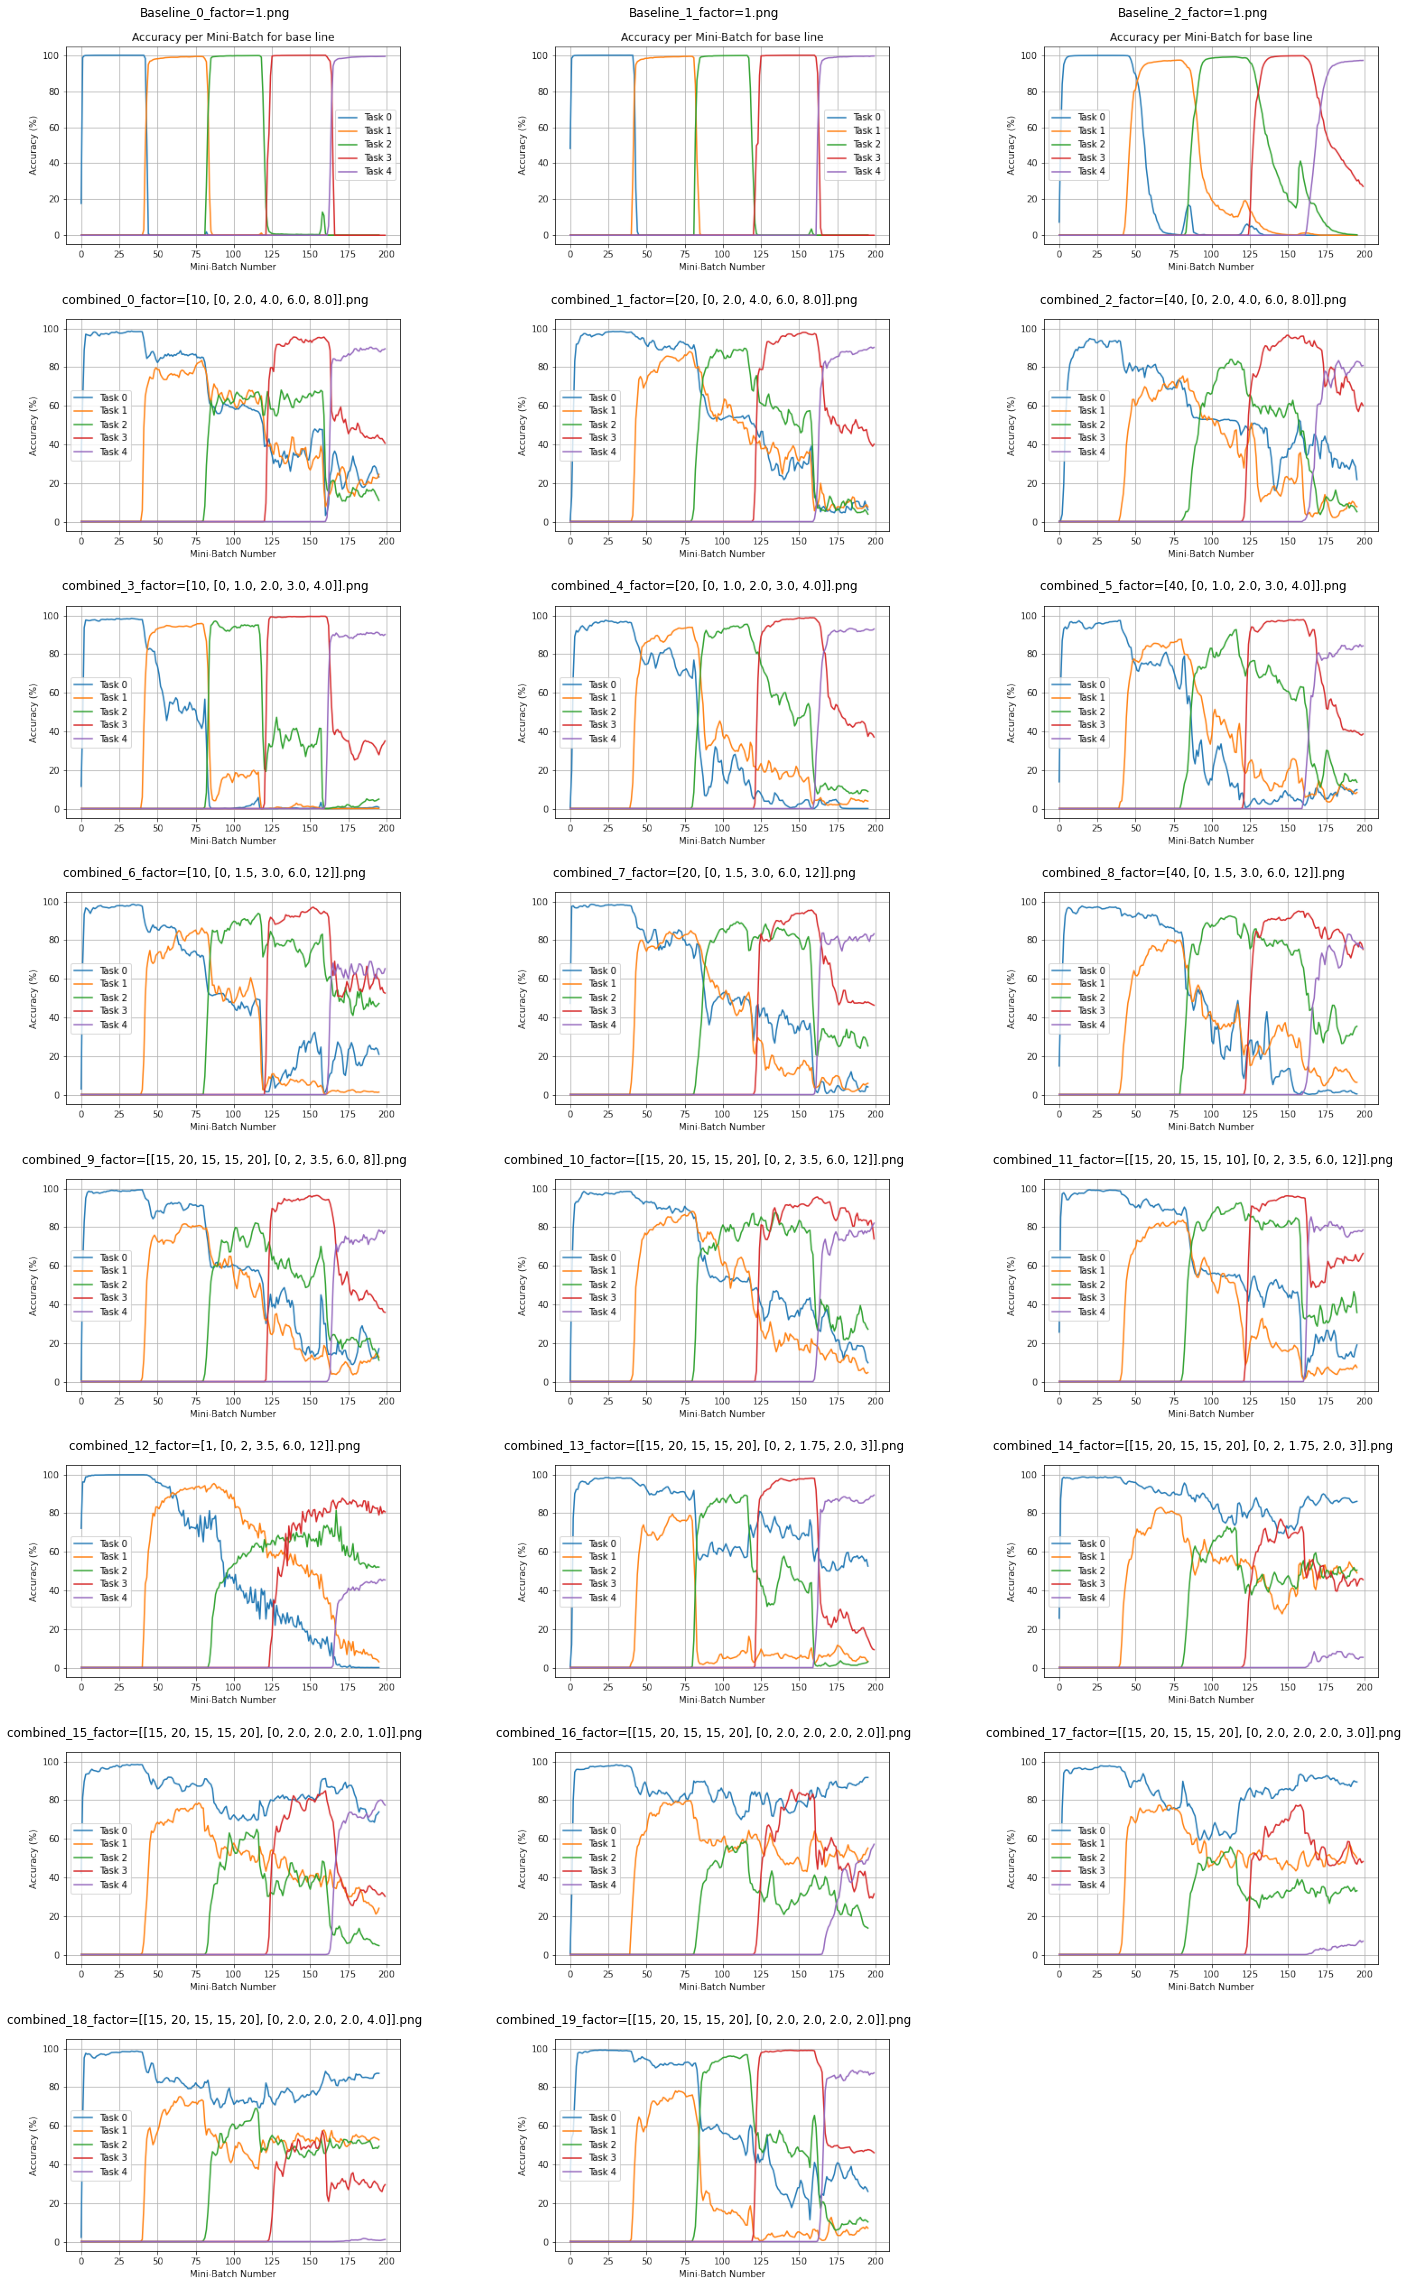

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import math

ncols = 3
nrows = math.ceil(len(train_settings.keys()) / 3.)

plt.figure(figsize=(21, 4 * nrows))  # Adjust the figure size based on the number of rows
for i, key in enumerate(train_settings.keys()):
    plt.subplot(nrows, ncols, i + 1)

    settings = train_settings[key]
    epochs, lr, l2, loss_type, factor = settings['epochs'], settings['lr'], settings['l2'], settings['loss_type'], settings['factor']

    file_name = f"{output_dir}/{key}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.png"
    try:
        with Image.open(file_name) as img:
            plt.imshow(img)
            plt.title(f"{key}_factor={factor}.png")
            plt.axis('off')
    except FileNotFoundError:
        print(f"Error: The file '{file_name}' does not exist.")
plt.tight_layout()
plt.show()  # Move plt.show() outside the loop to display all subplots at once


In [15]:
print(type(2))

<class 'int'>


In [16]:
print(isinstance(2, int))

True


In [17]:
print(isinstance([2, 3, 4], list))

True
